<a href="https://colab.research.google.com/github/SamGrievo/ResNet50MultiClassClasffication/blob/main/Blood_Classification_PCA(Not%20Complete).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import adam_v2
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage import io
from skimage.transform import resize


In [ ]:
#prepare image file paths
data = ['drive/MyDrive/dataset2-master/images/TRAIN', 'drive/MyDrive/dataset2-master/images/TEST']
path = 'drive/MyDrive/dataset2-master/images/TRAIN/EOSINOPHIL/_29_9452.jpeg'

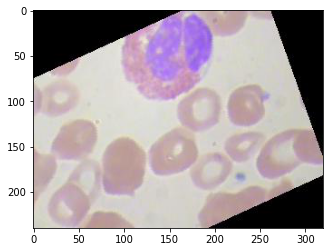

In [ ]:
#function to show example image
def read_and_show_image(path):

    test_image = io.imread(path)
    plt.imshow(test_image)
    plt.show()

read_and_show_image(path)

In [ ]:
#prepare arrays to images and image labels to be added
images = []
labels = []
count = 0

for dataset in data:
    # loop through the folders in the train set and test set
    for folder in os.listdir(dataset):

        #labels each string label with a key
        if folder in ['EOSINOPHIL']: label = 'EOSINOPHIL'
        elif folder in ['LYMPHOCYTE']: label = 'LYMPHOCYTE'
        elif folder in ['MONOCYTE']: label = 'MONOCYTE'
        elif folder in ['NEUTROPHIL']: label = 'NEUTROPHIL'

        # loop through the images in the datasets
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):

            # get pathname of each image to be read
            img_path = os.path.join(os.path.join(dataset, folder), file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (224,224))

            images.append(image)
            labels.append(label)



100%|██████████| 499/499 [00:05<00:00, 88.89it/s] 


In [ ]:
def split_array(image_list, label_list,split):
    new_images = []
    new_labels = []
    for i in range(len(labels)):
        if i % split == 0:
            new_images.append(image_list[i])
            new_labels.append(label_list[i])
        else:
            continue

    return new_images, new_labels

In [ ]:
split_images, split_labels = split_array(images,labels,10)

In [ ]:
print(len(split_labels))

809


In [ ]:
images_array = np.array(split_images, dtype = 'float32')

In [ ]:
labels_array = np.array(split_labels)

In [ ]:
print(len(labels_array))

809


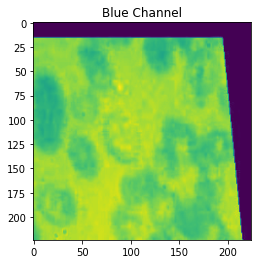

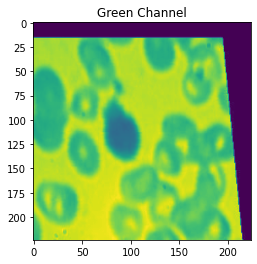

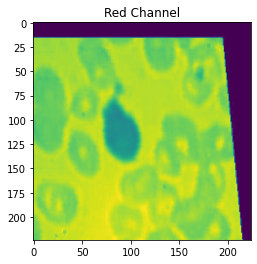

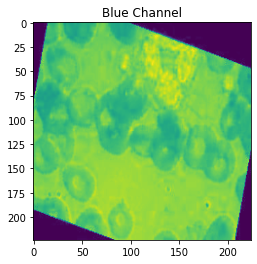

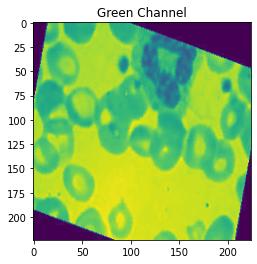

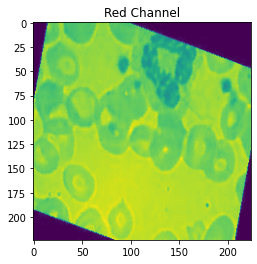

In [ ]:
from tensorflow.keras.utils import to_categorical
#train test split to split the images and labels into a training set and a testing set
x_train, x_test, y_train, y_test = train_test_split(images_array, labels_array, shuffle=True, random_state=42, test_size=0.25)

#split image into its colour channels
blue_train = []
green_train = []
red_train = []
blue_test = []
green_test = []
red_test = []

def get_channels(dataset,b_array,g_array,r_array):
  for i in range(len(dataset)):
    b,g,r = cv2.split(dataset[i])
    b_array.append(b)
    g_array.append(g)
    r_array.append(r)
  
get_channels(x_train,blue_train,green_train,red_train)
get_channels(x_test,blue_test,green_test,red_test)

blue_train = np.array(blue_train, dtype = 'float32')
green_train = np.array(green_train, dtype = 'float32')
red_train = np.array(red_train, dtype = 'float32')
blue_test = np.array(blue_test, dtype = 'float32')
green_test = np.array(green_test, dtype = 'float32')
red_test = np.array(red_test, dtype = 'float32')


plt.title("Blue Channel")
plt.imshow(blue_train[0])
plt.show()
plt.title("Green Channel")
plt.imshow(green_train[0])
plt.show()
plt.title("Red Channel")
plt.imshow(red_train[0])
plt.show()

plt.title("Blue Channel")
plt.imshow(blue_test[0])
plt.show()
plt.title("Green Channel")
plt.imshow(green_test[0])
plt.show()
plt.title("Red Channel")
plt.imshow(red_test[0])
plt.show()

In [ ]:
blue_train /= 255
green_train /= 255
red_train /= 255
blue_test /= 255
green_test /= 255
red_test /= 255 

from sklearn.decomposition import PCA

trans_blue_train = []
trans_green_train = []
trans_red_train = []
trans_blue_test = []
trans_green_test = []
trans_red_test = []


def pca_transform(dataset,array):
  for i in range(len(dataset)):
    pca_ch = PCA(n_components=50)
    pca_ch.fit(dataset[i])
    trans_pca = pca_ch.transform(dataset[i])
    
    reduce_img = pca_ch.inverse_transform(trans_pca)
    array.append(reduce_img)



pca_transform(blue_train,trans_blue_train)
pca_transform(green_train,trans_green_train)
pca_transform(red_train,trans_red_train)
pca_transform(blue_test,trans_blue_test)
pca_transform(green_test,trans_green_test)
pca_transform(red_test,trans_red_test)

# trans_blue_train = np.array(trans_blue_train, dtype = 'float32')
# trans_green_train = np.array(trans_green_train, dtype = 'float32')
# trans_red_train = np.array(trans_red_train, dtype = 'float32')
# trans_blue_test = np.array(trans_blue_test, dtype = 'float32')
# trans_green_test = np.array(trans_green_test, dtype = 'float32')
# trans_red_test = np.array(trans_red_test, dtype = 'float32')

In [ ]:
print(len(trans_red_test))

203


In [ ]:
x_train_reduced = []
x_test_reduced = []

def merge_channels(b_array,g_array,r_array,new_array):
  for i in range(len(b_array)):
    image = cv2.merge((b_array[i],g_array[i],r_array[i]))
    new_array.append(image)

merge_channels(trans_blue_train, trans_green_train, trans_red_train,x_train_reduced)
merge_channels(trans_blue_test, trans_green_test, trans_red_test, x_test_reduced)

In [ ]:
x_train_reduced = np.array(x_train_reduced, dtype='float32')
print(x_train_reduced.shape)
x_test_reduced = np.array(x_test_reduced, dtype='float32')
print(x_test_reduced.shape)

(606, 224, 224, 3)
(203, 224, 224, 3)


In [ ]:
#this will one hot encode the values so that each class is interpretable to the ResNet
def prepare_targets(y, y_t):
    le = LabelEncoder()
    le.fit(y)
    y_train_encode = le.transform(y)
    y_test_encode = le.transform(y_t)
    return y_train_encode, y_test_encode

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train_enc, 4)
y_test = to_categorical(y_test_enc, 4)
#display first training image and training label
print('Training set shapes:', x_train.shape, y_train.shape)

print('Label for first image in training set:', y_test)


Training set shapes: (606, 224, 224, 3) (606, 4)
Label for first image in training set: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0

In [ ]:
print(y_train)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [ ]:
model = ResNet50(classes=4, weights=None)

In [ ]:

#compile model, set metrics to evaluate training model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])

In [ ]:
model.fit(x_train_reduced,y_train, epochs=100, validation_split=0.1)

Epoch 1/100
18/18 [==============================] - 27s 472ms/step - loss: 2.3306 - accuracy: 0.3046 - recall: 0.2165 - precision: 0.3215 - val_loss: 1.5544 - val_accuracy: 0.3279 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 6s 307ms/step - loss: 1.6695 - accuracy: 0.3853 - recall: 0.2936 - precision: 0.4040 - val_loss: 1.9574 - val_accuracy: 0.3279 - val_recall: 0.3279 - val_precision: 0.3279
Epoch 3/100
18/18 [==============================] - 6s 315ms/step - loss: 1.3157 - accuracy: 0.5156 - recall: 0.4716 - precision: 0.5551 - val_loss: 2.6011 - val_accuracy: 0.3279 - val_recall: 0.3279 - val_precision: 0.3279
Epoch 4/100
18/18 [==============================] - 6s 311ms/step - loss: 1.3539 - accuracy: 0.5578 - recall: 0.4936 - precision: 0.5899 - val_loss: 2.1546 - val_accuracy: 0.2295 - val_recall: 0.2295 - val_precision: 0.2295
Epoch 5/100
18/18 [==============================] - 6s 311ms/step - loss: 1.3859 - accurac

In [ ]:
#evaluate model
evaluation = model.evaluate(x_test_reduced,y_test)

In [ ]:
print(evaluation)

In [ ]:
F1 = 2 * (evaluation[3] * evaluation[2]) / (evaluation[3] + evaluation[2])

In [ ]:
print('The average F1 score for all classes is:', F1)